In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model,load_model

In [2]:
name_lst = list(map(lambda x: x[7:-4], glob.glob(r"./data/*.csv")))
print(name_lst)
data = pd.read_csv('./data/SamsungE.csv', index_col = 0)
data.head()

['LGE', 'NAVER', 'SamsungBL', 'SamsungE', 'SamsungEU', 'SKH']


,weekdate,SamsungE_end,SamsungE_dpp,SamsungE_start,SamsungE_high,SamsungE_low,SamsungE_abount
date,,,,,,,
17/01/02,0,1805000,0.17,1799000,1812000,1794000,93012
17/01/03,1,1824000,1.05,1814000,1831000,1801000,147153
17/01/04,2,1808000,-0.88,1825000,1826000,1805000,159435
17/01/05,3,1778000,-1.66,1803000,1803000,1777000,219349
17/01/06,4,1810000,1.80,1809000,1822000,1802000,177619


In [3]:
datas = [pd.read_csv(path, index_col = 0) for path in glob.glob(r"./data/*.csv")]
data = datas[0]

for d in datas[1:]:
    data = pd.merge(data,d,left_index=True, right_index=True, on = 'weekdate')

data.head()

,weekdate,LGE_end,LGE_dpp,LGE_start,LGE_high,LGE_low,LGE_abount,NAVER_end,NAVER_dpp,NAVER_start,...,SamsungEU_start,SamsungEU_high,SamsungEU_low,SamsungEU_abount,SKH_end,SKH_dpp,SKH_start,SKH_high,SKH_low,SKH_abount
date,,,,,,,,,,,,,,,,,,,,,
17/01/02,0,51600,0.00,51800,52300,51600,431474,777000,0.26,778000,...,1432000,1448000,1415000,10822,45800,2.46,44750,46000,44600,1547681
17/01/03,1,54300,5.23,51800,54400,51800,1715000,767000,-1.29,777000,...,1440000,1448000,1422000,23904,47250,3.17,46200,47300,46200,2655477
17/01/04,2,53800,-0.92,54200,54500,53100,1262418,810000,5.61,775000,...,1451000,1452000,1425000,37092,46500,-1.59,47000,47150,46200,2722599
17/01/05,3,53600,-0.37,54000,55700,53400,1428250,791000,-2.35,810000,...,1430000,1433000,1411000,47714,46950,0.97,47000,47500,46850,2377163
17/01/06,4,52600,-1.87,53800,54000,52400,1382362,799000,1.01,791000,...,1430000,1438000,1423000,24743,48000,2.24,47700,48450,47600,3166843


In [4]:
def moving_window(data,sequence_num,step):
    X_train = []
    for i in range(0,len(data)-sequence_num,step):
        X_train.append(data[i:i+sequence_num])
    
    X_train = np.array(X_train)
    return X_train

train = moving_window(data,30,1)

def normalization(train):
    global name_lst
    for t in train:
        t[:,0] = t[:,0]/4
        for i in range(len(name_lst)):
            p_max = t.max(axis = 0)[4+ i*6]
            p_min = t.min(axis = 0)[5+ i*6]
            a_max = t.max(axis = 0)[6+ i*6]
            t[:,1+i*6] = (t[:,1+i*6] - p_min)/(p_max-p_min)
            t[:,3+i*6] = (t[:,3+i*6] - p_min)/(p_max-p_min)
            t[:,4+i*6] = (t[:,4+i*6] - p_min)/(p_max-p_min)
            t[:,5+i*6] = (t[:,5+i*6] - p_min)/(p_max-p_min)
            t[:,2+i*6] = t[:,2+i*6]/10
            t[:,6+i*6] = t[:,6+i*6]/a_max
            
normalization(train)
df = pd.DataFrame(train[0])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.00,0.037037,0.000,0.055556,0.101852,0.037037,0.188724,0.518987,0.026,0.531646,...,0.101449,0.178744,0.019324,0.006817,0.116505,0.246,0.014563,0.135922,0.000000,0.169686
1,0.25,0.287037,0.523,0.055556,0.296296,0.055556,0.750129,0.392405,-0.129,0.518987,...,0.140097,0.178744,0.053140,0.015058,0.257282,0.317,0.155340,0.262136,0.155340,0.291143
2,0.50,0.240741,-0.092,0.277778,0.305556,0.175926,0.552173,0.936709,0.561,0.493671,...,0.193237,0.198068,0.067633,0.023366,0.184466,-0.159,0.233010,0.247573,0.155340,0.298502
3,0.75,0.222222,-0.037,0.259259,0.416667,0.203704,0.624707,0.696203,-0.235,0.936709,...,0.091787,0.106280,0.000000,0.030057,0.228155,0.097,0.233010,0.281553,0.218447,0.260629
4,1.00,0.129630,-0.187,0.240741,0.259259,0.111111,0.604636,0.797468,0.101,0.696203,...,0.091787,0.130435,0.057971,0.015587,0.330097,0.224,0.300971,0.373786,0.291262,0.347208


In [5]:
nan_list = list(np.where(np.isnan(train)==True)[0])
train = np.delete(train, nan_list,0)

In [6]:
X = Input(shape=[29,37])
H = LSTM(64,activation = 'tanh', return_sequences = True)(X)
H = LSTM(32,activation = 'tanh', return_sequences = True)(H)
H = LSTM(16,activation = 'tanh', return_sequences = True)(H)
H = LSTM(8,activation = 'tanh', return_sequences = True)(H)
H = LSTM(4,activation = 'tanh', return_sequences = True)(H)
Y = LSTM(1,activation = 'tanh', return_sequences = False)(H)
LGE_model = Model(X, Y)

adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
LGE_model.compile(optimizer=adam,loss='mae')
LGE_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29, 37)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 29, 64)            26112     
_________________________________________________________________
lstm_1 (LSTM)                (None, 29, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 29, 16)            3136      
_________________________________________________________________
lstm_3 (LSTM)                (None, 29, 8)             800       
_________________________________________________________________
lstm_4 (LSTM)                (None, 29, 4)             208       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1)                 24    

In [7]:
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
LGE_model.compile(optimizer=adam,loss='mae')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
# callbacks=[early_stopping]
history = LGE_model.fit(train[:,0:29],train[:,29:30,2],epochs = 100,batch_size = 20, validation_split = 0.05)

Epoch 1/100
57/57 [==============================] - 13s 83ms/step - loss: 0.1811 - val_loss: 0.1898
Epoch 2/100
57/57 [==============================] - 2s 34ms/step - loss: 0.1773 - val_loss: 0.1894
Epoch 3/100
57/57 [==============================] - 2s 34ms/step - loss: 0.1751 - val_loss: 0.1886
Epoch 4/100
57/57 [==============================] - 2s 34ms/step - loss: 0.1688 - val_loss: 0.1886
Epoch 5/100
57/57 [==============================] - 2s 33ms/step - loss: 0.1743 - val_loss: 0.1891
Epoch 6/100
57/57 [==============================] - 2s 33ms/step - loss: 0.1673 - val_loss: 0.1887
Epoch 7/100
57/57 [==============================] - 2s 34ms/step - loss: 0.1708 - val_loss: 0.1892
Epoch 8/100
57/57 [==============================] - 2s 33ms/step - loss: 0.1735 - val_loss: 0.1885
Epoch 9/100
57/57 [==============================] - 2s 33ms/step - loss: 0.1716 - val_loss: 0.1885
Epoch 10/100
57/57 [==============================] - 2s 33ms/step - loss: 0.1854 - val_loss: 0.188

57/57 [==============================] - 2s 34ms/step - loss: 0.1682 - val_loss: 0.1883
Epoch 83/100
57/57 [==============================] - 2s 34ms/step - loss: 0.1617 - val_loss: 0.1887
Epoch 84/100
57/57 [==============================] - 2s 34ms/step - loss: 0.1645 - val_loss: 0.1890
Epoch 85/100
57/57 [==============================] - 2s 36ms/step - loss: 0.1735 - val_loss: 0.1919
Epoch 86/100
57/57 [==============================] - 2s 41ms/step - loss: 0.1752 - val_loss: 0.1878
Epoch 87/100
57/57 [==============================] - 2s 36ms/step - loss: 0.1662 - val_loss: 0.1907
Epoch 88/100
57/57 [==============================] - 2s 37ms/step - loss: 0.1663 - val_loss: 0.1899
Epoch 89/100
57/57 [==============================] - 2s 36ms/step - loss: 0.1606 - val_loss: 0.1897
Epoch 90/100
57/57 [==============================] - 2s 41ms/step - loss: 0.1689 - val_loss: 0.1893
Epoch 91/100
57/57 [==============================] - 2s 42ms/step - loss: 0.1592 - val_loss: 0.1898
Epo

In [8]:
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
LGE_model.compile(optimizer=adam,loss='mae')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
# callbacks=[early_stopping]
history = LGE_model.fit(train[:,0:29],train[:,29:30,2],epochs = 1000,batch_size = 20, validation_split = 0.05)

Epoch 1/1000
57/57 [==============================] - 15s 88ms/step - loss: 0.1764 - val_loss: 0.1934
Epoch 2/1000
57/57 [==============================] - 2s 37ms/step - loss: 0.1628 - val_loss: 0.1949
Epoch 3/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1599 - val_loss: 0.1947
Epoch 4/1000
57/57 [==============================] - 2s 37ms/step - loss: 0.1694 - val_loss: 0.1930
Epoch 5/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1658 - val_loss: 0.1942
Epoch 6/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1642 - val_loss: 0.1938
Epoch 7/1000
57/57 [==============================] - 2s 34ms/step - loss: 0.1723 - val_loss: 0.1947
Epoch 8/1000
57/57 [==============================] - 2s 37ms/step - loss: 0.1637 - val_loss: 0.1941
Epoch 9/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1627 - val_loss: 0.1922
Epoch 10/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1693 - val_l

57/57 [==============================] - 2s 33ms/step - loss: 0.1566 - val_loss: 0.1987
Epoch 82/1000
57/57 [==============================] - 2s 34ms/step - loss: 0.1477 - val_loss: 0.2065
Epoch 83/1000
57/57 [==============================] - 2s 34ms/step - loss: 0.1600 - val_loss: 0.1993
Epoch 84/1000
57/57 [==============================] - 2s 34ms/step - loss: 0.1531 - val_loss: 0.1991
Epoch 85/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.1471 - val_loss: 0.2037
Epoch 86/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.1509 - val_loss: 0.2025
Epoch 87/1000
57/57 [==============================] - 2s 34ms/step - loss: 0.1557 - val_loss: 0.1997
Epoch 88/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.1573 - val_loss: 0.2015
Epoch 89/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.1535 - val_loss: 0.1986
Epoch 90/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.1512 - val_loss: 0

Epoch 161/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1357 - val_loss: 0.2262
Epoch 162/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1410 - val_loss: 0.2236
Epoch 163/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1289 - val_loss: 0.2276
Epoch 164/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1412 - val_loss: 0.2236
Epoch 165/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1465 - val_loss: 0.2261
Epoch 166/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1365 - val_loss: 0.2223
Epoch 167/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1359 - val_loss: 0.2175
Epoch 168/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1289 - val_loss: 0.2256
Epoch 169/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1294 - val_loss: 0.2325
Epoch 170/1000
57/57 [==============================] - 2s 35ms/step - lo

57/57 [==============================] - 2s 35ms/step - loss: 0.1254 - val_loss: 0.2513
Epoch 241/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1157 - val_loss: 0.2511
Epoch 242/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1152 - val_loss: 0.2270
Epoch 243/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1257 - val_loss: 0.2468
Epoch 244/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1243 - val_loss: 0.2349
Epoch 245/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1109 - val_loss: 0.2503
Epoch 246/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1166 - val_loss: 0.2512
Epoch 247/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1143 - val_loss: 0.2486
Epoch 248/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1160 - val_loss: 0.2552
Epoch 249/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1158 - va

57/57 [==============================] - 2s 36ms/step - loss: 0.1138 - val_loss: 0.2521
Epoch 320/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1070 - val_loss: 0.2604
Epoch 321/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1061 - val_loss: 0.2585
Epoch 322/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1022 - val_loss: 0.2643
Epoch 323/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1019 - val_loss: 0.2553
Epoch 324/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1056 - val_loss: 0.2624
Epoch 325/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1075 - val_loss: 0.2590
Epoch 326/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1092 - val_loss: 0.2677
Epoch 327/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.1004 - val_loss: 0.2615
Epoch 328/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.1053 - va

57/57 [==============================] - 2s 35ms/step - loss: 0.0923 - val_loss: 0.2710
Epoch 399/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0868 - val_loss: 0.2655
Epoch 400/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0974 - val_loss: 0.2643
Epoch 401/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0925 - val_loss: 0.2650
Epoch 402/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0909 - val_loss: 0.2704
Epoch 403/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0915 - val_loss: 0.2701
Epoch 404/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0958 - val_loss: 0.2760
Epoch 405/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0958 - val_loss: 0.2699
Epoch 406/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0920 - val_loss: 0.2695
Epoch 407/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0945 - va

57/57 [==============================] - 2s 35ms/step - loss: 0.0777 - val_loss: 0.2719
Epoch 478/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0830 - val_loss: 0.2804
Epoch 479/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0883 - val_loss: 0.2754
Epoch 480/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0829 - val_loss: 0.2642
Epoch 481/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0803 - val_loss: 0.2757
Epoch 482/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0862 - val_loss: 0.2825
Epoch 483/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0856 - val_loss: 0.2775
Epoch 484/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0751 - val_loss: 0.2747
Epoch 485/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0825 - val_loss: 0.2741
Epoch 486/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0758 - va

57/57 [==============================] - 2s 36ms/step - loss: 0.0750 - val_loss: 0.2910
Epoch 557/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0703 - val_loss: 0.2886
Epoch 558/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0749 - val_loss: 0.2878
Epoch 559/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0645 - val_loss: 0.2937
Epoch 560/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0680 - val_loss: 0.2803
Epoch 561/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0797 - val_loss: 0.2928
Epoch 562/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0742 - val_loss: 0.2886
Epoch 563/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0747 - val_loss: 0.2920
Epoch 564/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0745 - val_loss: 0.2902
Epoch 565/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0722 - va

57/57 [==============================] - 2s 35ms/step - loss: 0.0603 - val_loss: 0.3065
Epoch 636/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0666 - val_loss: 0.3036
Epoch 637/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0645 - val_loss: 0.2992
Epoch 638/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0624 - val_loss: 0.2942
Epoch 639/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0542 - val_loss: 0.2984
Epoch 640/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0613 - val_loss: 0.3047
Epoch 641/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0593 - val_loss: 0.3047
Epoch 642/1000
57/57 [==============================] - 2s 37ms/step - loss: 0.0577 - val_loss: 0.2920
Epoch 643/1000
57/57 [==============================] - 2s 37ms/step - loss: 0.0604 - val_loss: 0.2993
Epoch 644/1000
57/57 [==============================] - 2s 37ms/step - loss: 0.0634 - va

57/57 [==============================] - 2s 35ms/step - loss: 0.0554 - val_loss: 0.3078
Epoch 715/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0556 - val_loss: 0.3230
Epoch 716/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0550 - val_loss: 0.3122
Epoch 717/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0511 - val_loss: 0.3206
Epoch 718/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0529 - val_loss: 0.3122
Epoch 719/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0568 - val_loss: 0.2958
Epoch 720/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0571 - val_loss: 0.3171
Epoch 721/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0610 - val_loss: 0.3151
Epoch 722/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0624 - val_loss: 0.3159
Epoch 723/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0525 - va

57/57 [==============================] - 2s 36ms/step - loss: 0.0467 - val_loss: 0.2994
Epoch 794/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0525 - val_loss: 0.3112
Epoch 795/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0494 - val_loss: 0.3156
Epoch 796/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0504 - val_loss: 0.3163
Epoch 797/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0487 - val_loss: 0.3252
Epoch 798/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0503 - val_loss: 0.3222
Epoch 799/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0553 - val_loss: 0.3065
Epoch 800/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0484 - val_loss: 0.3296
Epoch 801/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0496 - val_loss: 0.3059
Epoch 802/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0505 - va

57/57 [==============================] - 2s 36ms/step - loss: 0.0506 - val_loss: 0.3272
Epoch 873/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0447 - val_loss: 0.3100
Epoch 874/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0466 - val_loss: 0.3202
Epoch 875/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0450 - val_loss: 0.3029
Epoch 876/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0460 - val_loss: 0.3162
Epoch 877/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0494 - val_loss: 0.3037
Epoch 878/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0453 - val_loss: 0.3246
Epoch 879/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0545 - val_loss: 0.3003
Epoch 880/1000
57/57 [==============================] - 2s 35ms/step - loss: 0.0421 - val_loss: 0.3271
Epoch 881/1000
57/57 [==============================] - 2s 36ms/step - loss: 0.0445 - va

57/57 [==============================] - 2s 33ms/step - loss: 0.0442 - val_loss: 0.3198
Epoch 952/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.0418 - val_loss: 0.3178
Epoch 953/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.0377 - val_loss: 0.3006
Epoch 954/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.0401 - val_loss: 0.3048
Epoch 955/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.0387 - val_loss: 0.3370
Epoch 956/1000
57/57 [==============================] - 2s 32ms/step - loss: 0.0427 - val_loss: 0.3080
Epoch 957/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.0376 - val_loss: 0.2993
Epoch 958/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.0431 - val_loss: 0.3294
Epoch 959/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.0479 - val_loss: 0.3213
Epoch 960/1000
57/57 [==============================] - 2s 33ms/step - loss: 0.0434 - va

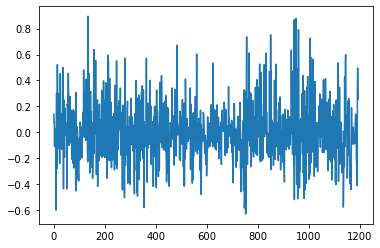

In [9]:
Y = LGE_model.predict(train[:,0:29])

plt.plot(Y)
plt.show()

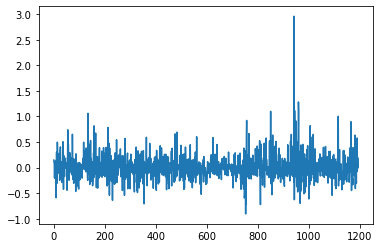

In [10]:
plt.plot(train[:,29:30,2])
plt.show()

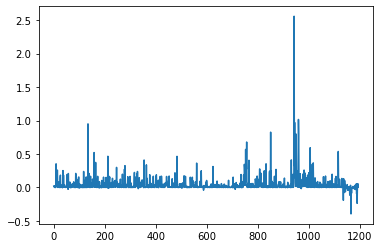

In [12]:
ev = train[:,29:30,2]*Y
plt.plot(ev)
plt.show()

In [13]:
len(np.where(ev > 0)[0])

1029